In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import *

## Define and Collect Trajectories of the Nonlinear System

In [2]:
def nonlinear_system(t,X,params):
    # define system parameters
    mu = params[0]
    lam = params[1]
    # specify rate of change of each state
    dx1dt = mu*X[0]
    dx2dt = lam*(X[1]-X[0]**2)
    # roll up states into a numpy array
    dXdt = np.asarray([dx1dt,dx2dt])
    
    return dXdt

In [24]:
# initial condition
initial_state = [-3.5,2]
dt = 0.01
final_time = 1000
t_vec = np.arange(0,final_time+dt,dt)
tspan = np.asarray([0,final_time])
mu = -0.05
lam = -1
params = np.asarray([mu,lam])

states = solve_ivp(nonlinear_system, tspan, initial_state, t_eval = t_vec, args = (params,))

t = states.t
x = states.y

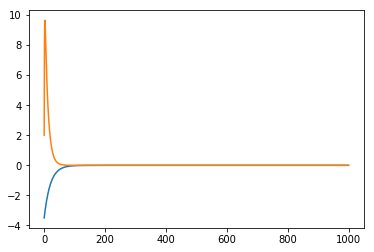

In [25]:
# plot trajectories
plt.plot(t,x[0,:],t,x[1,:])

## Perform DMD with and without Time Delay Embeddings and Visualize Mode Spectrum

In [26]:
def DMD(X,Xprime,r):
    ''' This function computes the linear approximation to a nonlinear dynamical system whose state 
    recordings are passed in.
    
    Arguments:
    
    Input:
    
        X: The states of the system
        
        Xprime: the rate of change of the states obtained form finite differencing or direct measurement
        
        r: the rank of the low-rank approximation
        
    Output:
    
        Phi: State transition matrix
        
        Lambda: Eigenvalues of Atilde
        
        b: Amplitude of the modes
    '''
    
    U,Sigma,VT = np.linalg.svd(X,full_matrices=0) # Step 1
    Ur = U[:,:r]
    Sigmar = np.diag(Sigma[:r])
    VTr = VT[:r,:]
    
    Atilde = np.linalg.solve(Sigmar.T,(Ur.T @ Xprime @ VTr.T).T).T # Step 2
    
    Lambda, W = np.linalg.eig(Atilde) # Step 3
    Lambda = np.diag(Lambda)
    
    Phi = Xprime @ np.linalg.solve(Sigmar.T,VTr).T @ W # Step 4
    alpha1 = Sigmar @ VTr[:,0]
    b = np.linalg.solve(W @ Lambda,alpha1)
    
    return Phi, Lambda, b

In [27]:
X = x[:,0:-1]
Xprime = x[:,1:]

# obtain DMD model
r = 3 # enter the value of r
Phi, Lambda, b = DMD(X[:,:],Xprime[:,:],r)
omega = np.log(np.diag(Lambda))/dt

In [28]:
# reconstruct dynamics with DMD as a sanity check

time_dynamics = np.zeros([2,len(t_vec)-1])

for i in range(time_dynamics.shape[1]):
    time_dynamics[:,i] = b*np.exp(omega*t_vec[i])
    
X_dmd = np.dot(Phi,time_dynamics)

Text(0, 0.5, 'Population')

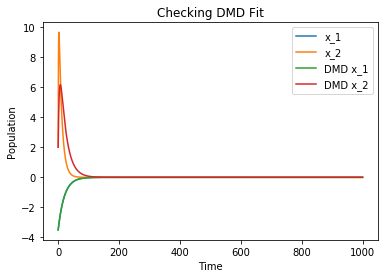

In [29]:
# plot to compare the DMD modes to the actual data
t = t_vec[:-1]
plt.plot(t,X[0,:],label='x_1')
plt.plot(t,X[1,:],label='x_2')
plt.plot(t,X_dmd[0,:],label='DMD x_1')
plt.plot(t,X_dmd[1,:],label='DMD x_2')
plt.legend()
plt.title("Checking DMD Fit")
plt.xlabel('Time')
plt.ylabel('Population')

(100, 99900)


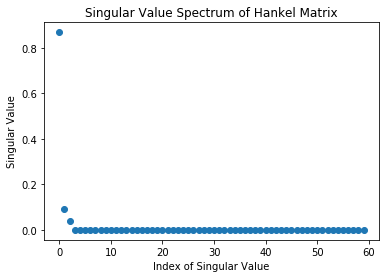

In [30]:
# time delay embedding

## Eigen-time delay coordinates
stackmax = 100 # Number of shift-stacked rows
r = 60  # rank of HAVOK model
num_states = 2
H = np.zeros((stackmax,X.shape[1]-stackmax))


for k in range(0,stackmax,num_states):
    H[k:k+2,:] = X[:,k:-(stackmax-k)]
  
U,S,VT = np.linalg.svd(H,full_matrices=0)
V = VT.T

S = S[:r]

plt.plot(S/np.sum(S),'o')
plt.title('Singular Value Spectrum of Hankel Matrix')
plt.ylabel('Singular Value')
plt.xlabel('Index of Singular Value')
print(H.shape)

In [31]:
latent_vars = np.where(S>1)[0]
print(latent_vars)

[0 1 2]


In [32]:
S

array([2.00120383e+03, 2.14646943e+02, 8.63535152e+01, 1.32296100e-01,
       5.89988472e-02, 1.84478158e-02, 6.08517268e-03, 2.75132913e-03,
       1.52906340e-03, 7.94102227e-04, 5.15702753e-04, 3.39382667e-04,
       2.28419517e-04, 1.68531367e-04, 1.25796887e-04, 9.18507450e-05,
       7.55285456e-05, 5.69358526e-05, 4.70251210e-05, 3.96278531e-05,
       3.13610303e-05, 2.79153742e-05, 2.31788697e-05, 1.97367070e-05,
       1.76306721e-05, 1.45936171e-05, 1.31062298e-05, 1.14274169e-05,
       9.93009602e-06, 9.07400800e-06, 7.93381489e-06, 7.19128977e-06,
       6.60725932e-06, 5.80804267e-06, 5.38728779e-06, 4.83491163e-06,
       4.39010996e-06, 4.06219880e-06, 3.64897386e-06, 3.40239840e-06,
       3.11141261e-06, 2.88202044e-06, 2.69428823e-06, 2.49453348e-06,
       2.35926488e-06, 2.22121548e-06, 2.11238601e-06, 2.03061749e-06,
       1.95362942e-06, 1.91340360e-06, 1.88365641e-06, 7.80571706e-07,
       2.43939029e-07, 4.42467591e-08, 2.08671991e-08, 9.19849139e-09,
      

In [12]:
# create the X and Xprime matrices of the dimelayed embeddings to pass to the DMD function
X_delay_prime = H[:,1:]
X_delay = H[:,:-1]

print(X_delay.shape,X_delay_prime.shape)
# obtain Time Delayed DMD model
r = 2 # enter the value of r
Phi_delay, Lambda_delay, b_delay = DMD(X_delay,X_delay_prime,r)
omega_delay = np.log(np.diag(Lambda_delay))/dt

print('Phi =',Phi_delay,'\n')
print('Lambda =',Lambda_delay,'\n')
print('b = ',b_delay,'\n')
print('Omega =',omega_delay)

(100, 199) (100, 199)
Phi = [[-0.04137244  0.00394936]
 [ 0.14026698 -0.21683413]
 [-0.04133109  0.00394541]
 [ 0.14008722 -0.21224875]
 [-0.04128978  0.00394147]
 [ 0.13990586 -0.20775484]
 [-0.04124851  0.00393753]
 [ 0.13972295 -0.20335056]
 [-0.04120729  0.00393359]
 [ 0.13953852 -0.19903414]
 [-0.0411661   0.00392966]
 [ 0.13935261 -0.19480386]
 [-0.04112495  0.00392573]
 [ 0.13916529 -0.19065811]
 [-0.04108385  0.00392181]
 [ 0.13897659 -0.18659525]
 [-0.04104279  0.00391789]
 [ 0.13878656 -0.18261371]
 [-0.04100176  0.00391397]
 [ 0.13859523 -0.17871191]
 [-0.04096078  0.00391006]
 [ 0.13840266 -0.17488828]
 [-0.04091984  0.00390615]
 [ 0.13820887 -0.17114129]
 [-0.04087894  0.00390225]
 [ 0.13801389 -0.16746941]
 [-0.04083808  0.00389835]
 [ 0.13781775 -0.16387114]
 [-0.04079727  0.00389445]
 [ 0.13762049 -0.160345  ]
 [-0.04075649  0.00389056]
 [ 0.13742211 -0.15688954]
 [-0.04071575  0.00388667]
 [ 0.13722265 -0.15350331]
 [-0.04067506  0.00388279]
 [ 0.13702214 -0.1501849 ]


In [13]:
# reconstruct dynamics with DMD as a sanity check

time_dynamics_delay = np.zeros([2,X_delay.shape[1]-1])

for i in range(time_dynamics_delay.shape[1]):
    time_dynamics_delay[:,i] = b_delay*np.exp(omega_delay*t_vec[i])
    
X_dmd_delay = np.dot(Phi_delay,time_dynamics_delay)

Text(0, 0.5, 'State')

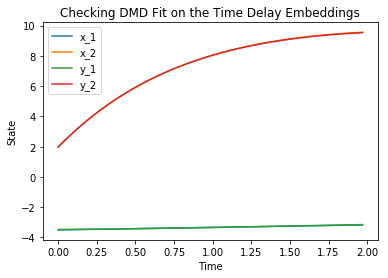

In [14]:
X_dmd_delay_model = X_dmd_delay[:,:]

# plot to compare the DMD modes to the actual data
end_delay = X_dmd_delay_model.shape[1]
t_delay = t[:end_delay]
plt.plot(t_delay,X[0,:end_delay],label='x_1')
plt.plot(t_delay,X[1,:end_delay],label='x_2')
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

## Compare against the Linearized System

In [15]:
def linear_system(t,Y,params):

    mu = params[0]
    lam = params[1]
    
    dy1dt = mu*Y[0]
    dy2dt = lam*Y[1]-lam*Y[2]
    dy3dt = 2*mu*Y[2]
    
    dYdt = np.asarray([dy1dt,dy2dt,dy3dt])
    
    return dYdt
    

In [16]:
def intrinsic_coords(x):
    y0 = x[0]
    y1 = x[1]
    y2 = x[0]**2
    
    y = np.asarray([y0,y1,y2])
    
    return y


In [17]:
initial_state_linear = intrinsic_coords(initial_state)

states_lin = solve_ivp(linear_system, tspan, initial_state_linear, t_eval = t_delay, args = (params,))

t_lin = states_lin.t
x_lin = states_lin.y

Text(0, 0.5, 'State')

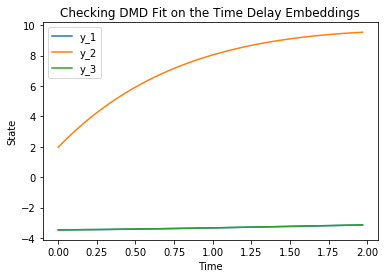

In [21]:
# plot to compare the DMD modes to the actual data
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.plot(t_delay,X_dmd_delay_model[2,:],label='y_3')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

Text(0, 0.5, 'State')

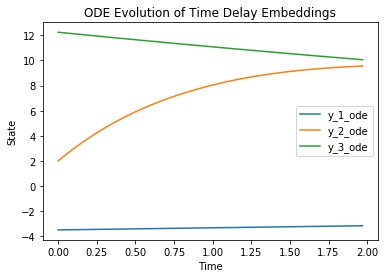

In [22]:
# plot to compare the DMD modes to the actual data
plt.plot(t_lin,x_lin[0,:],label='y_1_ode')
plt.plot(t_lin,x_lin[1,:],label='y_2_ode')
plt.plot(t_lin,x_lin[2,:],label='y_3_ode')
plt.legend()
plt.title("ODE Evolution of Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')

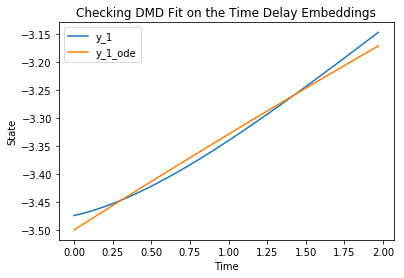

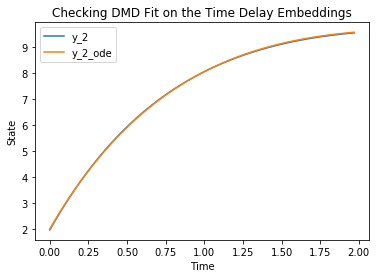

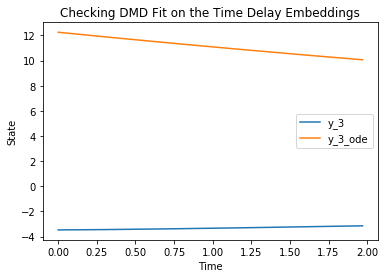

In [23]:
# plot to compare the DMD modes to the actual data
plt.plot(t_delay,X_dmd_delay_model[0,:],label='y_1')
plt.plot(t_lin,x_lin[0,:],label='y_1_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

plt.plot(t_delay,X_dmd_delay_model[1,:],label='y_2')
plt.plot(t_lin,x_lin[1,:],label='y_2_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

plt.plot(t_delay,X_dmd_delay_model[2,:],label='y_3')
plt.plot(t_lin,x_lin[2,:],label='y_3_ode')
plt.legend()
plt.title("Checking DMD Fit on the Time Delay Embeddings")
plt.xlabel('Time')
plt.ylabel('State')
plt.show()